# Exploring Policies
In this notebook, I explore the 

### About the policies
ABAC policy file has extension .abac.
* userAttrib(uid, attribute1=value1, attribute2=value2, ...): is automatically assigned to an attribute named "uid".
* resourceAttrib(rid, attribute1=value1, attribute2=value2, ...): is automatically assigned to an attribute named "rid".
* rule(ruleName; uae; pae; ops; con)
* unremovableUserAttribs(attribute1, attribute2, ...)
* unremovableResourceAttribs(attribute1, attribute2, ...)

*value1, value2,... are atomic values or sets.*
* an ***atomic*** value is a string that starts with a character other than a left curly brace.
* a ***set*** has the form "{element1 element2 ...}".  note that elements of a set are separated by spaces, not commas.

***uae*** is a user attribute expression. it is a conjunction, with the conjuncts separated by commas.
* each conjunct has the form $a \in \{value1, value2, \dots \}$ where $a$ is a *single-valued* user attribute, or 
* $a \subseteq \{set1, set2, \dots \}$ (meaning that $a$ is a *superset* of one of the sets in *{set1 set2 ...}*) where $a$ is a *multi-valued* user attribute, and *set1, set2, ...,* are sets of the form *{value1+value2+...}*".
* note that sets (such as set1, set2, ...) that are nested inside another set are written with the elements separated by "+" (instead of " ") to simplify parsing.

***rae*** is a resource attribute expression.  the syntax is analogous to the syntax for user attribute expressions.

***ops*** is a set of operations.

***con*** is a constraint.
* it is a conjunction of atomic constraints, with the conjuncts separated by commas.
* an *atomic constraint* is a formula of the form "*aum > arm, aum ] ars*", or *aus=ars$*, where
    * **aus** is a single-valued user
    * **aum** is a multi-valued user attribute,
    * **ars** is a single-valued resource attribute, and
    * **arm** is a multi-valued resource attribute.
* note that $>$ denotes $\supseteq$ and "]" denotes $\ni$.

the sets of users, resources, operations, user attributes, permission attributes, **are not specified explicitly**.  They are implicitly defined as the sets containing the users, permissions, etc., that are mentioned in the policy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit

### Auxiliar functions

In [2]:
###
class AccessLog:
    """ All operation in AccessLog (AL) """
    def __init__(self, df_users, df_rscs) -> None:
        """ Initialize AL attributes """
        self.df_users = df_users
        self.df_rscs = df_rscs
        self.user_attrs = df_users.columns
        self.rsrc_attrs = df_rscs.columns
        self.universal_access_log = []
    
    def compute_universal_al(self) -> None:
        """ Compute the universal Access Log (UAL). |UAL| = |U| x |R|"""
        access_log = []
        for user in self.df_users.values:
            for res in self.df_rscs.values:        
                access_log.append(list(user) + list(res))
        
        access_log = pd.DataFrame(access_log)
        access_log.columns = self.df_users.columns.append(self.df_rscs.columns)
        self.universal_access_log = access_log

    def policy_evaluation(self, policy) -> None:
        """ Compare each access record with a policy set."""
        false_negs = [] # False negatives
        true_pos = [] # True positives
        len_policy = len(policy)

        for acc_req in self.universal_access_log.iloc:
            denies_count = 0
            for rule in policy:
                res = True
                for item_rule in rule:
                    if item_rule[0] == 0:
                        if acc_req[item_rule[1]] != item_rule[2]:
                            res = False
                            break
                    if item_rule[0] == 1: # => attr1.val = attr2.val
                        if acc_req[item_rule[1]] != acc_req[item_rule[2]]:
                            res = False
                            break

                if res == False:
                    denies_count += 1
            if denies_count == len_policy:
                false_negs.append(acc_req)
            else:
                true_pos.append(acc_req)
        
        false_negs = pd.DataFrame(false_negs)
        true_pos = pd.DataFrame(true_pos)

        print("FN;", len(false_negs), "\t\tTP:", len(true_pos))

        # Add "ACTION" column
        false_negs["ACTION"] = 0
        true_pos["ACTION"] = 1

        # Access log with "ACTION" column
        self.universal_access_log = pd.concat([true_pos,false_negs])

    def get_sparse_al(self, fraction, random_state=None, previous_al=None):        
        """ Compute the sparse access log (SAL) version. """
        acc_log = self.universal_access_log
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al
        sparse_positive_al = None   
        pos_access_req = acc_log[acc_log["ACTION"]==1]
        if random_state != None:
            sparse_positive_al = pos_access_req.sample(frac=fraction,
                                                       random_state=random_state)
        else:
            sparse_positive_al = pos_access_req.sample(frac=fraction)

        return pd.concat([sparse_positive_al, acc_log[acc_log["ACTION"]==0]])

    def get_noisy_al(self, fraction, random_state=None, previous_al=None):
        """ Compute the noisy access log (NAL) version. """
        acc_log = self.universal_access_log
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al

        noysi_al = None
        if random_state != None:
            noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                      train_size = fraction,
                                                      random_state = random_state)
        else:
            noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                      train_size = fraction)
        
        noisy_acc_log_selection = noisy_separation.split(acc_log, acc_log.ACTION)
                        
        noisy_acc_req = None
        normal_acc_req = None
        for noisy_idx, normal_idx, in noisy_acc_log_selection:
            noisy_acc_req = acc_log.iloc[noisy_idx]
            normal_acc_req = acc_log.iloc[normal_idx]

        # Change the resolution in the noisy_selection dataset
        noisy_acc_req["ACTION"] = np.where(noisy_acc_req["ACTION"] == 0, 1, 0)

        noysi_al = pd.concat([noisy_acc_req, normal_acc_req])

        return noysi_al

    def get_balanced_al(self, positive_frac, random_state = None, previous_al = None):
        acc_log = self.universal_access_log
        
        if isinstance(previous_al, pd.DataFrame):
            acc_log = previous_al        

        # Compute the original balanced
        pos_acc_log = acc_log[acc_log["ACTION"]==1]
        neg_acc_log = acc_log[acc_log["ACTION"]==0]

        len_al = len(acc_log)
        len_pos_ar = len(pos_acc_log)

        limit_positive_frac = ( len_pos_ar * 100 ) / len_al

        if positive_frac < limit_positive_frac and positive_frac > 1:
            print("Is not possible")
            return
        
        len_neg_ar = int(( (1-positive_frac) * 100 * len_pos_ar ) / (positive_frac*100))        

        neg_acc_req = []
        if random_state != None:
            neg_acc_req = neg_acc_log.sample(n=len_neg_ar,
                                             random_state=random_state)
        else:
            neg_acc_req = neg_acc_log.sample(n=len_neg_ar)

        return pd.concat([pos_acc_log, neg_acc_req])

        


### Healthcare

In [3]:
# Load users
filepath = "../data/test.log"
df_users = pd.read_csv(filepath)
#df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users
print("###*** DF - USERS ***###")
print(df_users.info())

# Load resources
filepath = "../data/HC-res.csv"
df_res = pd.read_csv(filepath)
df_res = df_res[df_res.columns[1:]] # Remove the ID
df_res = df_res.drop_duplicates() # Remove deplicated resources
print("###*** DF - RESOURCES ***###")
print(df_res.info())

###*** DF - USERS ***###
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uname        31 non-null     object
 1   position     31 non-null     object
 2   uward        31 non-null     object
 3   specialties  31 non-null     object
 4   teams        31 non-null     object
 5   agentfor     31 non-null     object
dtypes: object(6)
memory usage: 1.7+ KB
None
###*** DF - RESOURCES ***###
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         31 non-null     object
 1   author       31 non-null     object
 2   patient      31 non-null     object
 3   topics       31 non-null     object
 4   tratingTeam  31 non-null     object
 5   rward        31 non-null     object
dtypes: object(6)
memory usage: 1.7+ KB
N

In [4]:
uniques = [df_res[i].unique().tolist() for i in df_res.columns]
df_res = pd.DataFrame(product(*uniques), columns = df_res.columns)
df_res["rname"] = df_res.index
df_res

,type,author,patient,topics,tratingTeam,rward,rname
0,HRitem,oncNurse1,oncPat1,oncology,oncTeam1,oncward,0
1,HRitem,oncNurse1,oncPat1,oncology,oncTeam1,carward,1
2,HRitem,oncNurse1,oncPat1,oncology,oncTeam2,oncward,2
3,HRitem,oncNurse1,oncPat1,oncology,oncTeam2,carward,3
4,HRitem,oncNurse1,oncPat1,oncology,carTeam1,oncward,4
...,...,...,...,...,...,...,...
4955,HR,carAgent1,carPat1,cardiology,oncTeam2,carward,4955
4956,HR,carAgent1,carPat1,cardiology,carTeam1,oncward,4956
4957,HR,carAgent1,carPat1,cardiology,carTeam1,carward,4957
4958,HR,carAgent1,carPat1,cardiology,carTeam2,oncward,4958


In [5]:
# 0 = attribute = value
# 1 = attribute = attribute => attribute.value = attribute.value
policy_hc = [
    [
        [0, "position", "nurse"],
        [0, "type", "HR"],
        [1, "uward", "rward"]
    ],
    [
        [0, "type", "HR"],
        [1, "tratingTeam", "teams"]
    ],
    [
        [0, "type", "HR"],
        [1, "uname", "patient"]
    ],
    [
        [0, "type", "HR"],
        [1, "patient", "agentfor"]
    ],

    [
        [0, "type", "HRItem"],
        [1, "uname", "author"]
    ],
    [
        [0, "position", "nurse"],
        [0, "type", "HRItem"],
        [0, "topics", "nursing"],
        [1, "uward", "rward"]
    ],
    [
        [0, "type", "HRItem"],
        [1, "topics", "specialties"],
        [1, "tratingTeam", "teams"]
    ],
    [
        [0, "type", "HRItem"],
        [0, "topics", "note"],
        [1, "uname", "patient"]
    ],
    [
        [0, "type", "HRItem"],
        [0, "topics", "note"],
        [1, "patient", "agentfor"]
    ]
]

In [6]:
# Policy summary
counter_len = 0
for rule in policy_hc:
    counter_len += len(rule)
print("|R|", len(policy_hc))
print("avg(R)", counter_len/len(policy_hc))
print("WSC", counter_len)


|R| 9
avg(R) 2.6666666666666665
WSC 24


In [7]:
hc_acc_log = AccessLog(df_users=df_users, df_rscs=df_res)
hc_acc_log.compute_universal_al()
hc_acc_log.policy_evaluation(policy_hc)
#hc_sparse_al = hc_acc_log.get_sparse_al(0.5)

FN; 133920 		TP: 19840


In [56]:
hc_noisy_al = hc_acc_log.get_noisy_al(0.1)

c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,uname,position,uward,specialties,teams,agentfor,type,author,patient,topics,tratingTeam,rward,rname,ACTION
95856,doc18,doctor,None,pediatrics,carTeam1,None,HRitem,doc19,oncPat1,note,oncTeam1,oncward,1616,1
81188,doc15,doctor,None,anesthesiology,None,None,HRitem,doc21,carPat1,none,carTeam1,oncward,1828,1
18972,doc2,doctor,None,oncology,oncTeam2,None,HR,doc19,oncPat1,nursing,carTeam1,oncward,4092,1
107004,doc20,doctor,None,pediatrics,None,None,HR,doc3,carPat1,oncology,carTeam1,oncward,2844,1
145707,oncAgent1,None,None,None,None,oncPat1,HRitem,doc22,oncPat1,none,oncTeam2,carward,1867,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125326,doc24,doctor,None,neurology,carTeam2,None,HRitem,doc15,carPat1,oncology,carTeam2,oncward,1326,0
148539,oncAgent1,None,None,None,None,oncPat1,HR,oncPat1,carPat1,note,oncTeam2,carward,4699,0
81178,doc15,doctor,None,anesthesiology,None,None,HRitem,doc21,carPat1,note,oncTeam2,oncward,1818,0
134572,oncPat1,None,oncward,None,None,None,HRitem,doc7,oncPat1,nursing,carTeam1,oncward,652,0


In [73]:
hc_balanced = hc_acc_log.get_balanced_al(0.5)

In [87]:
print("Total", len(hc_balanced), "\nL+= \n", hc_balanced.ACTION.value_counts())

Total 39680 
L+= 
 1    19840
0    19840
Name: ACTION, dtype: int64


In [90]:
print("Total", len(test), "\nL+= \n", test.ACTION.value_counts())

Total 39680 
L+= 
 0    19840
1    19840
Name: ACTION, dtype: int64


In [89]:
test = hc_acc_log.get_noisy_al(0.1, previous_al=hc_balanced)
test

c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,uname,position,uward,specialties,teams,agentfor,type,author,patient,topics,tratingTeam,rward,rname,ACTION
8193,carNurse1,nurse,carward,None,None,None,HR,doc8,oncPat1,cardiology,oncTeam1,carward,3233,0
152633,carAgent1,None,None,None,None,carPat1,HR,doc15,carPat1,cardiology,oncTeam1,carward,3833,0
72341,doc13,doctor,None,anesthesiology,carTeam1,None,HR,doc4,oncPat1,note,carTeam1,carward,2901,0
78620,doc14,doctor,None,anesthesiology,carTeam2,None,HR,doc20,carPat1,note,carTeam1,oncward,4220,1
58263,doc10,doctor,None,cardiology,None,None,HR,doc14,oncPat1,note,carTeam2,carward,3703,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63529,doc11,doctor,None,anesthesiology,oncTeam1,None,HR,doc18,oncPat1,nursing,oncTeam1,carward,4009,1
54287,doc9,doctor,None,cardiology,carTeam2,None,HR,oncPat1,carPat1,oncology,carTeam2,carward,4687,1
38240,doc6,doctor,None,cardiology,oncTeam1,None,HR,doc12,oncPat1,oncology,oncTeam1,oncward,3520,1
136802,oncPat1,None,oncward,None,None,None,HR,doc4,oncPat1,oncology,oncTeam2,oncward,2882,1


In [69]:
len(hc_balanced[hc_balanced.ACTION == 0])

19840

In [36]:
access_log = []
for user in df_users.values:
    for res in df_res.values:        
        access_log.append(list(user) + list(res))
        
access_log = pd.DataFrame(access_log)
access_log.columns = df_users.columns.append(df_res.columns)
access_log

,uname,position,uward,specialties,teams,agentfor,type,author,patient,topics,tratingTeam,rward,rname
0,oncNurse1,nurse,oncward,None,None,None,HRitem,oncNurse1,oncPat1,oncology,oncTeam1,oncward,0
1,oncNurse1,nurse,oncward,None,None,None,HRitem,oncNurse1,oncPat1,oncology,oncTeam1,carward,1
2,oncNurse1,nurse,oncward,None,None,None,HRitem,oncNurse1,oncPat1,oncology,oncTeam2,oncward,2
3,oncNurse1,nurse,oncward,None,None,None,HRitem,oncNurse1,oncPat1,oncology,oncTeam2,carward,3
4,oncNurse1,nurse,oncward,None,None,None,HRitem,oncNurse1,oncPat1,oncology,carTeam1,oncward,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153755,carAgent1,None,None,None,None,carPat1,HR,carAgent1,carPat1,cardiology,oncTeam2,carward,4955
153756,carAgent1,None,None,None,None,carPat1,HR,carAgent1,carPat1,cardiology,carTeam1,oncward,4956
153757,carAgent1,None,None,None,None,carPat1,HR,carAgent1,carPat1,cardiology,carTeam1,carward,4957
153758,carAgent1,None,None,None,None,carPat1,HR,carAgent1,carPat1,cardiology,carTeam2,oncward,4958


In [37]:
false_negs = []
positive_ar = []
for row in access_log.iloc:
    # Evaluation
    denies_count = 0    
    for rule in policy_hc:
        res = True

        for item_rule in rule:    
            if item_rule[0] == 0:# Check type of typle => Attr=Value
                if row[item_rule[1]] != item_rule[2]:
                    res = False
                    break
            if item_rule[0] == 1: # => attr1.val = attr2.val
                if row[item_rule[1]] != row[item_rule[2]]:
                    res = False
                    break
            if item_rule[0] == 2: # val1 in {val1, val2, val3}
                if not row[item_rule[1]] in row[item_rule[2]]:
                    res = False
                    break
        if res == False:
            denies_count += 1
    if denies_count == len(policy_hc):        
        false_negs.append(row)
    else:
        positive_ar.append(row)

false_negs = pd.DataFrame(false_negs)
positive_ar = pd.DataFrame(positive_ar)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
print("FN;", len(false_negs), "\t\tTP:", len(positive_ar))


FN; 133920 		TP: 19840


In [38]:
false_negs["ACTION"] = 0
positive_ar["ACTION"] = 1

universal_access_log = pd.concat([positive_ar, false_negs])
print("L:", len(universal_access_log),
      "\tL+:", len(universal_access_log[universal_access_log.ACTION==1]),
      "\tL-:", len(universal_access_log[universal_access_log.ACTION==0]))

L: 153760 	L+: 19840 	L-: 133920


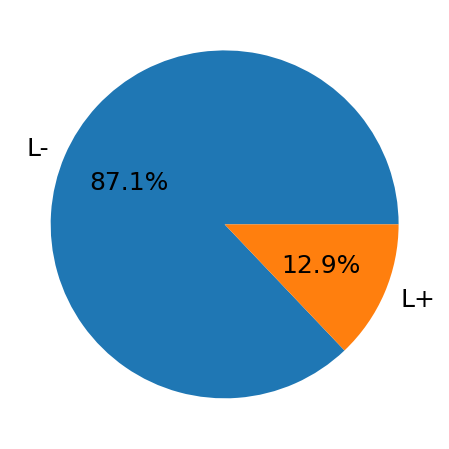

In [19]:
sizes = [len(false_negs), len(positive_ar)]
fontdict_labels = {'fontsize': 25}
fig, ax = plt.subplots(figsize=(8,8))
color_palette = ['#1e81b0', '#e28743', '#9BC1BC', '#5CA4A9', '#E6EBE0']
color_palette = ['#5CA4A9', '#ED6A5A', '#9BC1BC', '#5CA4A9', '#E6EBE0']
ax.pie(sizes, labels=["L-","L+"],
        autopct='%1.1f%%', textprops=fontdict_labels)
plt.show()

In [39]:
### Select a sample of "positive access log"
sparse_percentage = 0.5 # a value between 0 and 1
sparse_pos_ar = positive_ar.sample(frac=sparse_percentage)
sparse_pos_ar

,uname,position,uward,specialties,teams,agentfor,type,author,patient,topics,tratingTeam,rward,rname,ACTION
37513,doc6,doctor,None,cardiology,oncTeam1,None,HR,doc2,carPat1,cardiology,oncTeam1,carward,2793,1
93498,doc17,doctor,None,pediatrics,oncTeam2,None,HR,doc20,carPat1,note,oncTeam2,oncward,4218,1
77087,doc14,doctor,None,anesthesiology,carTeam2,None,HR,doc1,carPat1,oncology,carTeam2,carward,2687,1
112184,doc21,doctor,None,neurology,oncTeam1,None,HR,doc6,oncPat1,none,oncTeam1,oncward,3064,1
136649,oncPat1,None,oncward,None,None,None,HR,doc2,oncPat1,nursing,oncTeam1,carward,2729,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13096,doc1,doctor,None,oncology,oncTeam1,None,HR,doc7,carPat1,note,oncTeam1,oncward,3176,1
39592,doc6,doctor,None,cardiology,oncTeam1,None,HR,oncAgent1,carPat1,cardiology,oncTeam1,oncward,4872,1
97077,doc18,doctor,None,pediatrics,carTeam1,None,HR,doc3,oncPat1,cardiology,carTeam1,carward,2837,1
97277,doc18,doctor,None,pediatrics,carTeam1,None,HR,doc5,carPat1,cardiology,carTeam1,carward,3037,1


In [40]:
len(positive_ar)*.5

9920.0

In [23]:
### Noisy dataset
noisy_percentage = 0.1 # a value between 0 and 1
noisy_separation = StratifiedShuffleSplit(n_splits=1, train_size=noisy_percentage)
nal_selection = noisy_separation.split(universal_access_log, universal_access_log.ACTION)
train = None
test = None
for train_d, test_d in nal_selection:
    # Get the row by id
    train, test = universal_access_log.iloc[train_d], universal_access_log.iloc[test_d]    

train

,uname,position,uward,specialties,teams,agentfor,type,author,patient,topics,tratingTeam,rward,rname,ACTION
41431,doc7,doctor,None,cardiology,oncTeam2,None,HRitem,doc20,carPat1,none,carTeam2,carward,1751,0
139394,carPat1,None,carward,None,None,None,HRitem,doc5,oncPat1,cardiology,oncTeam2,oncward,514,0
46745,doc8,doctor,None,cardiology,carTeam1,None,HRitem,doc25,oncPat1,none,oncTeam1,carward,2105,0
75416,doc14,doctor,None,anesthesiology,carTeam2,None,HRitem,doc11,carPat1,note,oncTeam1,oncward,1016,0
43096,doc7,doctor,None,cardiology,oncTeam2,None,HR,doc10,carPat1,note,oncTeam1,oncward,3416,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128418,doc24,doctor,None,neurology,carTeam2,None,HR,doc23,oncPat1,note,oncTeam2,oncward,4418,0
120813,doc23,doctor,None,neurology,carTeam1,None,HRitem,doc21,oncPat1,nursing,carTeam1,carward,1773,0
41388,doc7,doctor,None,cardiology,oncTeam2,None,HRitem,doc20,oncPat1,none,carTeam1,oncward,1708,0
27684,doc4,doctor,None,oncology,carTeam2,None,HR,doc4,oncPat1,oncology,carTeam1,oncward,2884,0


In [24]:
train["ACTION"] = np.where(train["ACTION"] == 0, 1, 0)
train

c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,uname,position,uward,specialties,teams,agentfor,type,author,patient,topics,tratingTeam,rward,rname,ACTION
41431,doc7,doctor,None,cardiology,oncTeam2,None,HRitem,doc20,carPat1,none,carTeam2,carward,1751,1
139394,carPat1,None,carward,None,None,None,HRitem,doc5,oncPat1,cardiology,oncTeam2,oncward,514,1
46745,doc8,doctor,None,cardiology,carTeam1,None,HRitem,doc25,oncPat1,none,oncTeam1,carward,2105,1
75416,doc14,doctor,None,anesthesiology,carTeam2,None,HRitem,doc11,carPat1,note,oncTeam1,oncward,1016,1
43096,doc7,doctor,None,cardiology,oncTeam2,None,HR,doc10,carPat1,note,oncTeam1,oncward,3416,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128418,doc24,doctor,None,neurology,carTeam2,None,HR,doc23,oncPat1,note,oncTeam2,oncward,4418,1
120813,doc23,doctor,None,neurology,carTeam1,None,HRitem,doc21,oncPat1,nursing,carTeam1,carward,1773,1
41388,doc7,doctor,None,cardiology,oncTeam2,None,HRitem,doc20,oncPat1,none,carTeam1,oncward,1708,1
27684,doc4,doctor,None,oncology,carTeam2,None,HR,doc4,oncPat1,oncology,carTeam1,oncward,2884,1


In [25]:
noisy_access_log = pd.concat([train, test])
noisy_access_log

,uname,position,uward,specialties,teams,agentfor,type,author,patient,topics,tratingTeam,rward,rname,ACTION
41431,doc7,doctor,None,cardiology,oncTeam2,None,HRitem,doc20,carPat1,none,carTeam2,carward,1751,1
139394,carPat1,None,carward,None,None,None,HRitem,doc5,oncPat1,cardiology,oncTeam2,oncward,514,1
46745,doc8,doctor,None,cardiology,carTeam1,None,HRitem,doc25,oncPat1,none,oncTeam1,carward,2105,1
75416,doc14,doctor,None,anesthesiology,carTeam2,None,HRitem,doc11,carPat1,note,oncTeam1,oncward,1016,1
43096,doc7,doctor,None,cardiology,oncTeam2,None,HR,doc10,carPat1,note,oncTeam1,oncward,3416,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127352,doc24,doctor,None,neurology,carTeam2,None,HR,doc9,carPat1,cardiology,oncTeam1,oncward,3352,0
67278,doc12,doctor,None,anesthesiology,oncTeam2,None,HR,doc2,carPat1,cardiology,carTeam2,oncward,2798,0
67089,doc12,doctor,None,anesthesiology,oncTeam2,None,HR,carNurse1,carPat1,nursing,oncTeam1,carward,2609,0
122096,doc23,doctor,None,neurology,carTeam1,None,HR,doc6,oncPat1,note,oncTeam1,oncward,3056,0


In [26]:
false_negs.to_csv("../data/HC-ALL-negative_ar.csv")
positive_ar.to_csv("HC-ALL-positive_ar.csv")

del false_negs
del positive_ar

In [27]:
#pos_ar = pd.read_csv("../data/HC-ALL-positive_ar.csv")
pos_ar = pd.read_csv("HC-ALL-positive_ar.csv")
print(pos_ar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19840 entries, 0 to 19839
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   19840 non-null  int64 
 1   uname        19840 non-null  object
 2   position     19840 non-null  object
 3   uward        19840 non-null  object
 4   specialties  19840 non-null  object
 5   teams        19840 non-null  object
 6   agentfor     19840 non-null  object
 7   type         19840 non-null  object
 8   author       19840 non-null  object
 9   patient      19840 non-null  object
 10  topics       19840 non-null  object
 11  tratingTeam  19840 non-null  object
 12  rward        19840 non-null  object
 13  rname        19840 non-null  int64 
 14  ACTION       19840 non-null  int64 
dtypes: int64(3), object(12)
memory usage: 2.3+ MB
None


In [28]:
len(pos_ar.uname.value_counts())

26

In [29]:
fpath = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")
fpath2 = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")


In [30]:
pos_ar.rname.drop_duplicates()

0       2480
1       2482
2       2484
3       2486
4       2488
        ... 
2475    4951
2476    4953
2477    4955
2478    4957
2479    4959
Name: rname, Length: 2480, dtype: int64

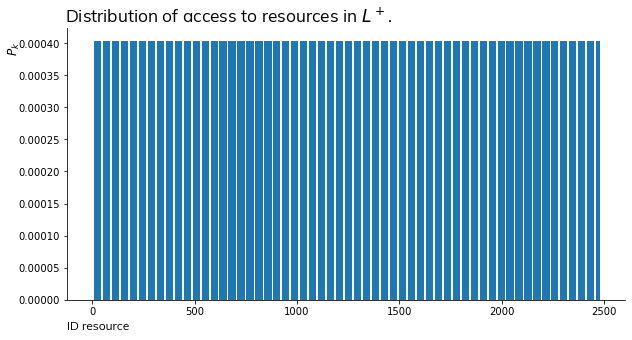

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = pos_ar.rname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
plt.savefig("HC-AccessDistribution.svg")
plt.show()

In [ ]:
pos_ar.uname.drop_duplicates()

0           0
1040        1
2340        2
3640        3
4940        4
         ... 
682240    805
683150    806
684060    807
684580    808
685490    809
Name: uname, Length: 768, dtype: int64

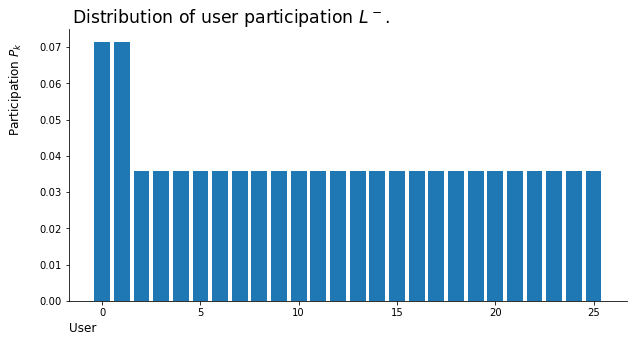

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = pos_ar.uname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('User', loc="left", size="large")
ax.set_ylabel('Participation $P_k$', loc="top", size="large")
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of user participation $L^-$.", size="xx-large", x=0.29, y=1)
plt.savefig("HC-UserDistri.svg")
plt.show()

In [ ]:
a = false_negs[false_negs.type=="HR"]
a = a[a.teams!="None"]
a[["teams", "tratingTeam"]]

,teams,tratingTeam
71,oncTeam1,oncTeam2
75,oncTeam1,carTeam1
79,oncTeam1,carTeam2
83,oncTeam2,oncTeam1
91,oncTeam2,carTeam1
95,oncTeam2,carTeam2
103,oncTeam1,oncTeam2
107,oncTeam1,carTeam1
111,oncTeam1,carTeam2
115,oncTeam2,oncTeam1


In [ ]:
class User:
    def __init__(self, name, position , uward , specialties , teams , agentfor) -> None:
        self.name = name
        self.position = position
        self.ward = uward
        self.specialties = specialties
        self.teams = teams
        self.agentfor = agentfor        

    def __str__(self) -> str:
        return self.name

class Users:
    def __init__(self, dataframe) -> None:
        self.df = dataframe
        self.attrs = dataframe.columns
        self.users = []        
    
    def build_list(self) -> None:
        """Create a list of user object"""
        rows = self.df.values        
        for i in rows:
            self.users.append(User(i[0], i[1], i[2], i[3], i[4], i[5]))
        print("Done")

    def users_size(self):
        return len(self.users)
    
class Rule:
    def __init__(self, attribute_expression) -> None:
        rule = []
        for item in attribute_expression: # For each attribute expression
            if item[0] == 0: # attribute = value

        pass

### Project Manager

In [ ]:
policy_pm = [
    [
        [0, "adminroles", "manager"],
        [0, "type", "budget"],
        [1, "department", "departmentu"]
    ],
    [
        [0, "type", "schedule"],
        [1, "projectsled", "project"]
    ],
    [
        [0, "type", "budget"],
        [1, "projectsled", "project"]
    ],
    [
        [0, "type", "schedule"],
        [0, "projects", "project"]
    ],
    [
        [0, "type", "task"],
        [0, "task", "rname"]
    ],
    [
        [0, "type", "task"],
        [0, "proprietary", "0"],
        [1, "project", "projects"],
        [1, "expertise", "expertiseu"]
    ],
    [
        [0, "isemployee","0"],
        [0, "type", "task"],
        [1, "project", "projects"],
        [1, "expertise", "expertiseu"]
    ],
    [
        [0, "adminroles", "auditor"],
        [0, "type", "budget"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "accountant"],
        [0, "type", "budget"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "accountant"],
        [0, "type", "task"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "planner"],
        [0, "type", "schedule"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "planner"],
        [0, "type", "task"],
        [1, "project", "projects"]
    ]
]

In [ ]:
counter_len = 0
for rule in policy_pm:
    counter_len += len(rule)
print("|R|", len(policy_pm))
print("avg(R)", counter_len/len(policy_pm))
print("WSC", counter_len)


|R| 12
avg(R) 2.8333333333333335
WSC 34


In [ ]:
result_counter = 0
result_times = 1
for col in df_res:    
    unique_values = df_res[col].drop_duplicates()
    #print(unique_values)
    if "none" in list(unique_values):
        print("si")
        result_counter -= 1
        print(col, len(unique_values)-1)
        result_times *= (len(unique_values)-1)
    else:
        print(col, len(unique_values))
        result_times *= len(unique_values)
    result_counter += len(unique_values)    
    print(list(unique_values))

print(result_counter, result_times)

type 2
['HRitem', 'HR']
author 31
['oncNurse1', 'carNurse1', 'doc1', 'doc2', 'doc3', 'doc4', 'doc5', 'doc6', 'doc7', 'doc8', 'doc9', 'doc10', 'doc11', 'doc12', 'doc13', 'doc14', 'doc15', 'doc16', 'doc17', 'doc18', 'doc19', 'doc20', 'doc21', 'doc22', 'doc23', 'doc24', 'doc25', 'oncPat1', 'carPat1', 'oncAgent1', 'carAgent1']
patient 2
['oncPat1', 'carPat1']
si
topics 4
['oncology', 'nursing', 'note', 'none', 'cardiology']
tratingTeam 4
['oncTeam1', 'oncTeam2', 'carTeam1', 'carTeam2']
rward 2
['oncward', 'carward']
45 3968


In [ ]:
result_counter = 0
result_times = 1
for col in df_users:    
    unique_values = df_users[col].drop_duplicates()
    #print(unique_values)
    if "none" in list(unique_values):
        print("si")
        result_counter -= 1
        print(col, len(unique_values)-1)
        result_times *= (len(unique_values)-1)
    else:
        print(col, len(unique_values))
        result_times *= len(unique_values)
    result_counter += len(unique_values)    
    print(list(unique_values))

print(result_counter, result_times)

uname 31
['oncNurse1', 'carNurse1', 'doc1', 'doc2', 'doc3', 'doc4', 'doc5', 'doc6', 'doc7', 'doc8', 'doc9', 'doc10', 'doc11', 'doc12', 'doc13', 'doc14', 'doc15', 'doc16', 'doc17', 'doc18', 'doc19', 'doc20', 'doc21', 'doc22', 'doc23', 'doc24', 'doc25', 'oncPat1', 'carPat1', 'oncAgent1', 'carAgent1']
position 3
['nurse', 'doctor', 'None']
uward 3
['oncward', 'carward', 'None']
specialties 6
['None', 'oncology', 'cardiology', 'anesthesiology', 'pediatrics', 'neurology']
teams 5
['None', 'oncTeam1', 'oncTeam2', 'carTeam1', 'carTeam2']
agentfor 3
['None', 'oncPat1', 'carPat1']
51 25110


In [ ]:
# Load user and resource data
filepath = "../data/PM-users.csv"
df_users = pd.read_csv(filepath) # Users
df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users

filepath = "../data/PM-res.csv"
df_res = pd.read_csv(filepath)  # Resources
#df_res = df_res[df_res.columns[1:]]
df_res = df_res.drop_duplicates() # Remove deplicated users

print(df_users.info(), df_res.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 77
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   adminroles   78 non-null     object
 1   projects     78 non-null     object
 2   departmentu  78 non-null     object
 3   projectsled  78 non-null     object
 4   expertiseu   78 non-null     object
 5   isemployee   78 non-null     object
 6   task         78 non-null     object
dtypes: object(7)
memory usage: 4.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rname        40 non-null     object
 1   type         40 non-null     object
 2   project      40 non-null     object
 3   department   40 non-null     object
 4   expertise    40 non-null     object
 5   proprietary  40 non-null     object
dtypes: object(6)
memory usage: 2.2+ KB
None None


In [ ]:
df_users_sample = df_users.iloc[46:]
df_users_sample = df_users_sample[["projects", "expertiseu", "isemployee", "task"]]

uniques = [df_users_sample[i].unique().tolist() for i in df_users_sample.columns]
df_users_sample = pd.DataFrame(product(*uniques), columns = df_users_sample.columns)
#df_users_sample["uname"] = df_users_sample.index
df_users_sample

,projects,expertiseu,isemployee,task
0,proj11,design,1,proj11task1a
1,proj11,design,1,proj11task2a
2,proj11,design,1,proj11task1
3,proj11,design,1,proj11task2
4,proj11,design,1,proj11task1propa
...,...,...,...,...
507,proj22,coding,0,proj22task2
508,proj22,coding,0,proj22task1propa
509,proj22,coding,0,proj22task2propa
510,proj22,coding,0,proj22task1prop


In [ ]:
df_users_test = df_users.drop(range(46, len(df_users)))
df_users_test = pd.concat([df_users_test, df_users_sample])
df_users_test["uname"] = df_users_test.index
df_users_test

,adminroles,projects,departmentu,projectsled,expertiseu,isemployee,task,uname
0,accountant,proj11,none,none,none,none,none,0
1,accountant,proj21,none,none,none,none,none,1
2,accountant,proj12,none,none,none,none,none,2
3,accountant,proj22,none,none,none,none,none,3
4,auditor,proj11,none,none,none,none,none,4
...,...,...,...,...,...,...,...,...
507,NaN,proj22,NaN,NaN,coding,0,proj22task2,507
508,NaN,proj22,NaN,NaN,coding,0,proj22task1propa,508
509,NaN,proj22,NaN,NaN,coding,0,proj22task2propa,509
510,NaN,proj22,NaN,NaN,coding,0,proj22task1prop,510


In [ ]:
access_log = []
for user in df_users_test.values:
    for res in df_res.values:        
        access_log.append(list(user) + list(res))
        
access_log = pd.DataFrame(access_log)
access_log.columns = df_users_test.columns.append(df_res.columns)
access_log

,adminroles,projects,departmentu,projectsled,expertiseu,isemployee,task,uname,rname,type,project,department,expertise,proprietary
0,accountant,proj11,none,none,none,none,none,0,proj11budget,budget,proj11,dept1,none,none
1,accountant,proj11,none,none,none,none,none,0,proj11sched,schedule,proj11,dept1,none,none
2,accountant,proj11,none,none,none,none,none,0,proj11task1a,task,proj11,dept1,design,0
3,accountant,proj11,none,none,none,none,none,0,proj11task2a,task,proj11,dept1,coding,0
4,accountant,proj11,none,none,none,none,none,0,proj11task1,task,proj11,dept1,design,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22315,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task2,task,proj22,dept2,coding,0
22316,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task1propa,task,proj22,dept2,design,1
22317,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task2propa,task,proj22,dept2,coding,1
22318,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,proj22task1prop,task,proj22,dept2,design,1


In [ ]:
false_negs = []
positive_ar = []
for row in access_log.iloc:
    # Evaluation
    denies_count = 0    
    for rule in policy_pm:
        res = True

        for item_rule in rule:    
            if item_rule[0] == 0:# Check type of typle => Attr=Value
                if row[item_rule[1]] != item_rule[2]:
                    res = False
                    break
            if item_rule[0] == 1: # => attr1.val = attr2.val                 
                if row[item_rule[1]] != row[item_rule[2]]:
                    res = False
                    break
            if item_rule[0] == 2: # val1 in {val1, val2, val3}
                if not row[item_rule[1]] in row[item_rule[2]]:
                    res = False
                    break
        if res == False:
            denies_count += 1
    if denies_count == len(policy_pm):        
        false_negs.append(row)
    else:
        positive_ar.append(row)

false_negs = pd.DataFrame(false_negs)
positive_ar = pd.DataFrame(positive_ar)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
print("FN;", len(false_negs), "\t\tTP:", len(positive_ar))


FN; 20640 		TP: 1680


In [ ]:
false_negs.to_csv("../data/PM-ALL-negative_ar.csv")
positive_ar.to_csv("../data/PM-ALL-positive_ar.csv")

del false_negs
del positive_ar

In [ ]:
positive_ar = pd.read_csv("../data/PM-ALL-positive_ar.csv")

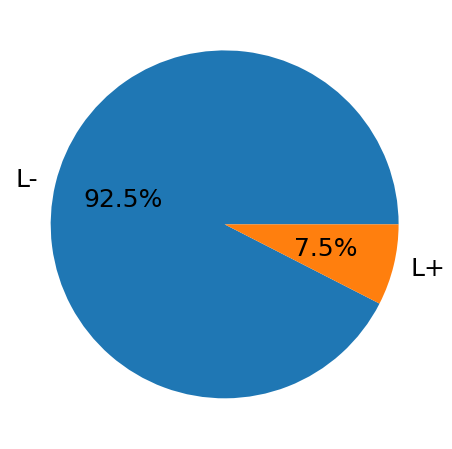

In [ ]:
sizes = [20640, 1680]
fontdict_labels = {'fontsize': 25}
fig, ax = plt.subplots(figsize=(8,8))
color_palette = ['#1e81b0', '#e28743', '#9BC1BC', '#5CA4A9', '#E6EBE0']
color_palette = ['#5CA4A9', '#ED6A5A', '#9BC1BC', '#5CA4A9', '#E6EBE0']
ax.pie(sizes, labels=["L-","L+"],
        autopct='%1.1f%%', textprops=fontdict_labels)
plt.show()

In [ ]:
len(positive_ar.rname.drop_duplicates())

40

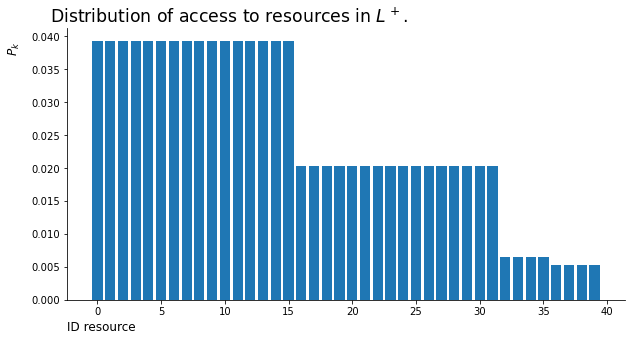

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = positive_ar.rname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large")
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  x=0.29, y=1)
plt.savefig("HC-AccessDistribution.svg")
plt.show()

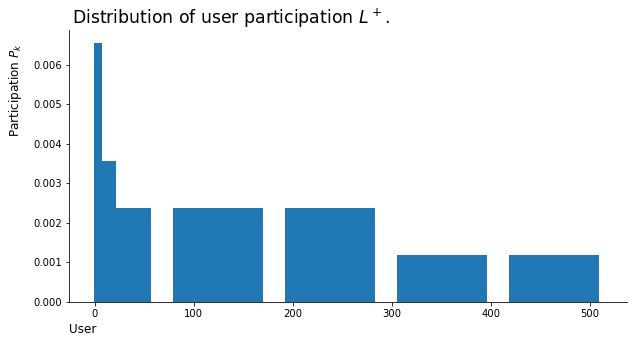

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = positive_ar.uname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('User', loc="left", size="large")
ax.set_ylabel('Participation $P_k$', loc="top", size="large")
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of user participation $L^+$.", size="xx-large", x=0.29, y=1)
plt.savefig("HC-UserDistri.svg")
plt.show()

### University

In [ ]:
policy_un = [
    [
        [0,"type", "gradebook"],
        [1, "crsTaken", "csr"]
    ],
    [
        [0,"type", "gradebook"],
        [1, "crsTaught", "csr"]
    ],
    [
        [0, "position", "faculty"],
        [0,"type", "gradebook"],
        [1, "crsTaught", "csr"]
    ],
    [
        [0, "departmentu", "registrar"],
        [0, "type", "roster"]
    ],
    [
        [0, "position", "faculty"],
        [0, "type", "roster"],
        [1, "crsTaught", "csr"]
    ],
    [
        [0, "type", "transcript"],
        [1, "uname", "student"]
    ],
    [
        [0, "isChair", 1],
        [0, "type", "transcript"],
        [1, "rDepartment", "departmentu"]
    ],
    [
        [0, "departmentu", "registrar"],
        [0, "type", "transcript"],
    ],
    [
        [0, "type", "application"],
        [1, "uname", "student"]
    ],
    [
        [0, "departmentu", "admissions"],
        [0, "type", "application"],
    ]
]

In [ ]:
counter_len = 0
for rule in policy_un:
    counter_len += len(rule)
print("|R|", len(policy_pm))
print("avg(R)", counter_len/len(policy_pm))
print("WSC", counter_len)

|R| 12
avg(R) 1.9166666666666667
WSC 23


In [ ]:
# Load user and resource data
filepath = "../data/UN-users.csv"
df_users = pd.read_csv(filepath) # Users
#df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users

filepath = "../data/UN-res.csv"
df_res = pd.read_csv(filepath)  # Resources
#df_res = df_res[df_res.columns[1:]]
df_res = df_res.drop_duplicates() # Remove deplicated users

print(df_users.info(), df_res.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uname        101 non-null    object
 1   position     101 non-null    object
 2   departmentu  101 non-null    object
 3   crsTaken     101 non-null    object
 4   crsTaught    101 non-null    object
 5   isChair      101 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 5.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 276
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rName        277 non-null    object
 1   type         277 non-null    object
 2   student      277 non-null    object
 3   rDepartment  277 non-null    object
 4   csr          277 non-null    object
dtypes: object(5)
memory usage: 13.0+ KB
None None


In [ ]:
result_counter = 0
result_times = 1
for col in df_res:    
    unique_values = df_res[col].drop_duplicates()
    #print(unique_values)
    if "none" in list(unique_values):
        print("si")
        result_counter -= 1
        print(col, len(unique_values)-1)
        result_times *= (len(unique_values)-1)
    else:
        print(col, len(unique_values))
        result_times *= len(unique_values)
    result_counter += len(unique_values)    
    print(list(unique_values))

print(result_counter, result_times)

rName 24
['cs101gradebook', 'cs601gradebook', 'cs602gradebook', 'ee101gradebook', 'ee601gradebook', 'ee602gradebook', 'cs101roster', 'cs601roster', 'cs602roster', 'ee101roster', 'ee601roster', 'ee602roster', 'application1', 'csStu1application', 'csStu2application', 'csStu3application', 'csStu4application', 'csStu5application', 'eeStu1application', 'eeStu2application', 'eeStu3application', 'eeStu4application', 'eeStu5application', 'csStu1trans']
type 4
['gradebook', 'roster', 'application', 'transcript']
si
student 85
['none', 'applicant1', 'csStu1', 'csStu2', 'csStu3', 'csStu4', 'csStu5', 'csStu6', 'csStu7', 'csStu8', 'csStu9', 'csStu10', 'csStu11', 'csStu12', 'csStu13', 'csStu14', 'csStu15', 'csStu16', 'csStu17', 'csStu18', 'csStu19', 'csStu20', 'csStu21', 'csStu22', 'csStu23', 'csStu24', 'csStu25', 'csStu26', 'csStu27', 'csStu28', 'csStu29', 'csStu30', 'csStu31', 'csStu32', 'csStu33', 'csStu34', 'csStu35', 'csStu36', 'csStu37', 'csStu38', 'csStu39', 'csStu40', 'csStu41', 'csStu42', '

In [ ]:
result_counter = 0
result_times = 1
for col in df_users:    
    unique_values = df_users[col].drop_duplicates()
    #print(unique_values)
    if "none" in list(unique_values):
        print("si")
        result_counter -= 1
        print(col, len(unique_values)-1)
        result_times *= (len(unique_values)-1)
    else:
        print(col, len(unique_values))
        result_times *= len(unique_values)
    result_counter += len(unique_values)    
    print(list(unique_values))

print(result_counter, result_times)

uname 101
['applicant1', 'csStu1', 'csStu2', 'csStu3', 'csStu4', 'csStu5', 'csStu6', 'csStu7', 'csStu8', 'csStu9', 'csStu10', 'csStu11', 'csStu12', 'csStu13', 'csStu14', 'csStu15', 'csStu16', 'csStu17', 'csStu18', 'csStu19', 'csStu20', 'csStu21', 'csStu22', 'csStu23', 'csStu24', 'csStu25', 'csStu26', 'csStu27', 'csStu28', 'csStu29', 'csStu30', 'csStu31', 'csStu32', 'csStu33', 'csStu34', 'csStu35', 'csStu36', 'csStu37', 'csStu38', 'csStu39', 'csStu40', 'csStu41', 'csStu42', 'csStu43', 'csStu44', 'csStu45', 'csStu46', 'csStu47', 'csStu48', 'csStu49', 'csStu50', 'csStu51', 'csStu52', 'csStu53', 'csStu54', 'csStu55', 'csStu56', 'csStu57', 'csStu58', 'csStu59', 'csStu60', 'csStu61', 'csStu62', 'csStu63', 'csStu64', 'csStu65', 'csStu66', 'csStu67', 'csStu68', 'csStu69', 'csStu70', 'csStu71', 'csStu72', 'csStu73', 'csStu74', 'csStu75', 'csStu76', 'csStu77', 'csStu78', 'csStu79', 'csStu80', 'csStu81', 'csStu82', 'csStu83', 'csStu84', 'csFac1', 'csFac2', 'csFac3', 'csFac4', 'csFac5', 'csFac6', 

In [ ]:
access_log = []
for user in df_users.values:
    for res in df_res.values:        
        access_log.append(list(user) + list(res))
        
access_log = pd.DataFrame(access_log)
access_log.columns = df_users.columns.append(df_res.columns)
access_log

,uname,position,departmentu,crsTaken,crsTaught,isChair,rName,type,student,rDepartment,csr
0,applicant1,applicant,none,none,none,0,cs101gradebook,gradebook,none,cs,cs101
1,applicant1,applicant,none,none,none,0,cs601gradebook,gradebook,none,cs,cs601
2,applicant1,applicant,none,none,none,0,cs602gradebook,gradebook,none,cs,cs602
3,applicant1,applicant,none,none,none,0,ee101gradebook,gradebook,none,cs,ee101
4,applicant1,applicant,none,none,none,0,ee601gradebook,gradebook,none,cs,ee601
...,...,...,...,...,...,...,...,...,...,...,...
27972,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu80,ee,none
27973,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu81,ee,none
27974,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu82,ee,none
27975,admissions1,staff,admissions,none,none,0,csStu1trans,transcript,csStu83,ee,none


In [ ]:
false_negs = []
positive_ar = []
for row in access_log.iloc:
    # Evaluation
    denies_count = 0    
    for rule in policy_un:
        res = True

        for item_rule in rule:    
            
            if item_rule[0] == 0:# Check type of typle => Attr=Value
                if row[item_rule[1]] != item_rule[2]:
                    res = False
                    break
            if item_rule[0] == 1: # => attr1.val = attr2.val
                
                if row[item_rule[1]] != row[item_rule[2]]:
                    res = False
                    break
            if item_rule[0] == 2: # val1 in {val1, val2, val3}
                if not row[item_rule[1]] in row[item_rule[2]]:
                    res = False
                    break
        if res == False:
            denies_count += 1
    if denies_count == len(policy_un):        
        false_negs.append(row)
    else:
        positive_ar.append(row)

false_negs = pd.DataFrame(false_negs)
positive_ar = pd.DataFrame(positive_ar)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
print("FN;", len(false_negs), "\t\tTP:", len(positive_ar))


FN; 26955 		TP: 1022


In [ ]:
false_negs.to_csv("../data/UN-ALL-negative_ar.csv")
positive_ar.to_csv("../data/UN-ALL-positive_ar.csv")

del false_negs
del positive_ar

In [ ]:
positive_ar = pd.read_csv("../data/UN-ALL-positive_ar.csv")

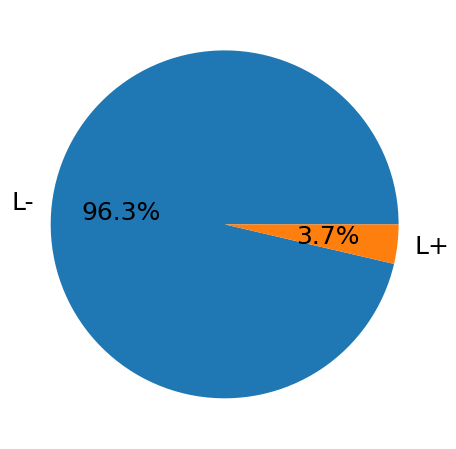

In [ ]:
sizes = [26955, 1022]
fontdict_labels = {'fontsize': 25}
fig, ax = plt.subplots(figsize=(8,8))
color_palette = ['#1e81b0', '#e28743', '#9BC1BC', '#5CA4A9', '#E6EBE0']
color_palette = ['#5CA4A9', '#ED6A5A', '#9BC1BC', '#5CA4A9', '#E6EBE0']
ax.pie(sizes, labels=["L-","L+"],
        autopct='%1.1f%%', textprops=fontdict_labels)
plt.show()

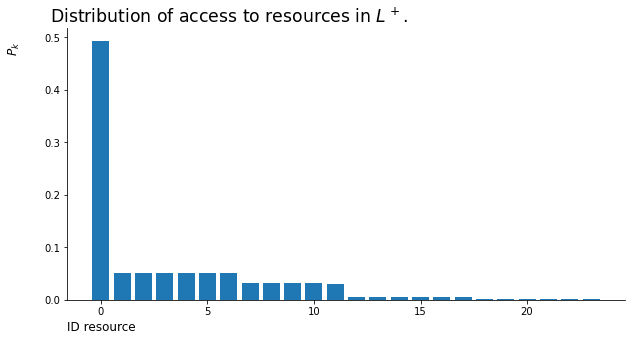

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = positive_ar.rName.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large")
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  x=0.29, y=1)
plt.savefig("HC-AccessDistribution.svg")
plt.show()

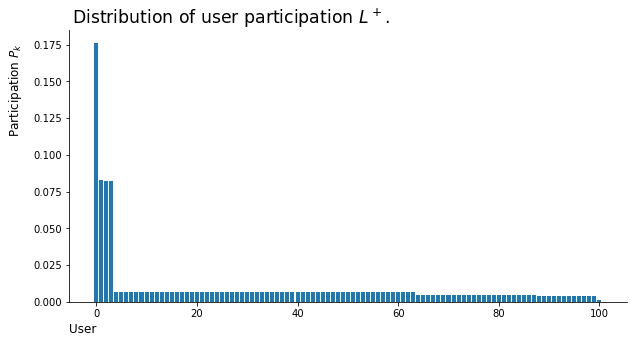

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = positive_ar.uname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('User', loc="left", size="large")
ax.set_ylabel('Participation $P_k$', loc="top", size="large")
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of user participation $L^+$.", size="xx-large", x=0.29, y=1)
plt.savefig("HC-UserDistri.svg")
plt.show()

### AMZ

In [ ]:
access_log = pd.read_csv("../../00-Data/new/amz-kaggle.csv")
access_log = access_log[access_log.ACTION==1]
print(access_log.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30872 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            30872 non-null  int64
 1   RID               30872 non-null  int64
 2   MGR_ID            30872 non-null  int64
 3   ROLE_ROLLUP_1     30872 non-null  int64
 4   ROLE_ROLLUP_2     30872 non-null  int64
 5   ROLE_DEPTNAME     30872 non-null  int64
 6   ROLE_TITLE        30872 non-null  int64
 7   ROLE_FAMILY_DESC  30872 non-null  int64
 8   ROLE_FAMILY       30872 non-null  int64
 9   ROLE_CODE         30872 non-null  int64
dtypes: int64(10)
memory usage: 2.6 MB
None


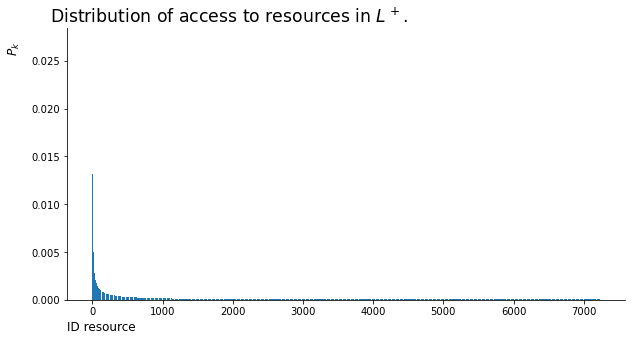

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = access_log.RID.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large")
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  x=0.29, y=1)
plt.savefig("HC-AccessDistribution.svg")
plt.show()

In [ ]:

# Data statistics
n_users = len(access_log[access_log.columns[2:]].drop_duplicates())
n_rsrcs = len(access_log.RID.drop_duplicates())
print("|U|: ", n_users) # Usuarios únicos
print("|R|: ", n_rsrcs) # Registros únicos

# Add and index for every unique user
user_dict = {}
for u_idx, u_attr in enumerate(access_log[access_log.columns[2:]].drop_duplicates().values):
    idx = str(u_idx) + "101"
    user_dict[int(idx)] = list(u_attr)
print("|U| :", len(user_dict))

# Create a new column to add in a DF
list_usr_idx = []
key_list = list(user_dict.keys()) # list out keys and values separately
val_list = list(user_dict.values())
for log in access_log[access_log.columns[2:]].values:
    key_idx = val_list.index(list(log))
    list_usr_idx.append(key_list[key_idx])
print("|L'| :", len(list_usr_idx), " = |L| :", len(access_log))
access_log["USERID"] = list_usr_idx

|U|:  9298
|R|:  7226
|U| : 9298
|L'| : 30872  = |L| : 30872


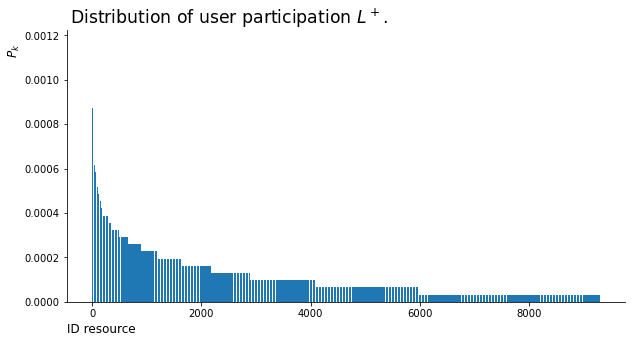

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = access_log.USERID.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large")
ax.set_ylabel('$P_k$', loc="top", size="large")
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of user participation $L^+$.", size="xx-large", x=0.29, y=1)
plt.savefig("HC-a.svg")
plt.show()

### AMZ UCI

In [ ]:
access_log = pd.read_csv("../../00-Data/new/amz-uci.csv")
access_log = access_log[access_log.ACTION==1]
print(access_log.info())